# Machine Learning - Precios Propiedades (Versión 4)

In [ ]:
import pandas as pd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Lectura de datos

In [ ]:
DIR = "/content/drive/MyDrive/DATA MINING/fcen-dm-2025-prediccion-precio-de-propiedades/entrenamiento"

In [ ]:
df_ent = pd.read_csv(f"{DIR}/entrenamiento.csv", index_col="id")
df_ent.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,NaN,...,2.0,NaN,NaN,USD,NaN,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta,259000.0
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,NaN,...,1.0,74.0,47.0,USD,NaN,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta,140000.0
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,NaN,...,1.0,66.0,64.0,USD,NaN,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta,173000.0
383947,Propiedad,2019-10-23,2019-11-08,2019-10-23,-58.420780,-34.608640,Argentina,Capital Federal,Almagro,NaN,...,1.0,55.0,55.0,USD,NaN,Depto.tipo casa de 3 ambientes en Venta en Alm...,"Muy Lindo ph al contrafrente con 2 patios!, 80...",PH,Venta,155000.0
986212,Propiedad,2019-08-01,2019-08-14,2019-08-01,-58.371394,-34.621835,Argentina,Capital Federal,San Telmo,NaN,...,1.0,42.0,42.0,USD,NaN,Ph en edificio de estilo Frances . 2 dormitori...,PH en Edificio Frances en Estado original!!!al...,PH,Venta,74000.0


## 1. Entender los datos (AID)

In [ ]:
#Años que comprende el dataset df_ent
df_ent['start_date'] = pd.to_datetime(df_ent['start_date'], errors='coerce')
años_unicos = sorted(df_ent['start_date'].dt.year.dropna().unique())
print(años_unicos)

[np.int32(2019), np.int32(2020)]


## 2. Limpiar y transformar los datos (MD)

In [ ]:
# Calculo cuartiles para filtrar outliers
q1_price = df_ent["price"].quantile(0.01)
q99_price = df_ent["price"].quantile(0.99)

q1_surf_total = df_ent["surface_total"].quantile(0.01)
q99_surf_total = df_ent["surface_total"].quantile(0.99)

q1_surf_cov = df_ent["surface_covered"].quantile(0.01)
q99_surf_cov = df_ent["surface_covered"].quantile(0.99)

In [ ]:
# Selección de datos.
df_ent = df_ent.loc[
    (df_ent["price"].notna()) &
    ((df_ent["currency"] == "USD") | (df_ent["currency"] == "ARS")) &
    (df_ent["l2"] == "Capital Federal") &
    (df_ent["operation_type"] == "Venta") &
    (df_ent["property_type"].isin(["Cochera", "Departamento", "Casa"])) &
    (df_ent["price"].between(q1_price, q99_price)) &
    (df_ent["surface_total"].between(q1_surf_total, q99_surf_total)) &
    (df_ent["surface_covered"].between(q1_surf_cov, q99_surf_cov))
]
df_ent.shape

(71949, 24)

In [ ]:
#Valor del dolar. Fuente: datos.gob.ar
dolar = {"Enero2019" : 37.35,
         "Febrero2019" : 38.34,
         "Marzo2019" : 41.32,
         "Abril2019" : 43.21,
         "Mayo2019" : 44.82,
         "Junio2019" : 43.74,
         "Julio2019" : 42.47,
         "Agosto2019" : 52.24,
         "Septiembre2019" : 56.69,
         "Octubre2019" : 58.52,
         "Noviembre2019" : 59.71,
         "Diciembre2019" : 58.88,
         "Enero2020" : 59.98,
         "Febrero2020" : 61.34,
         "Marzo2020" : 63.25,
         "Abril2020" : 65.68,
         "Mayo2020" : 67.71,
         "Junio2020" : 69.55,
         "Julio2020" : 71.38,
         "Agosto2020" : 73.25,
         "Septiembre2020" : 75.18,
         "Octubre2020" : 77.56,
         "Noviembre2020" : 79.90,
         "Diciembre2020" : 82.64}
meses = {1:"Enero", 2:"Febrero", 3:"Marzo", 4:"Abril", 5:"Mayo", 6:"Junio",
          7:"Julio", 8:"Agosto", 9:"Septiembre", 10:"Octubre", 11:"Noviembre", 12:"Diciembre"}

In [ ]:
#Convertir precios en ARS a USD
df_ent['created_on'] = pd.to_datetime(df_ent['created_on'], errors='coerce')
df_ent['clave_tc']  = df_ent['created_on'].dt.month.map(meses) + df_ent['created_on'].dt.year.astype(str)
df_ent['tc_ars_usd'] = df_ent['clave_tc'].map(dolar)

df_ent['price_usd'] = df_ent['price'].where(
    df_ent['currency'] == 'USD', df_ent['price'] / df_ent['tc_ars_usd'])

<ipython-input-256-c0a4b8ea898b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['created_on'] = pd.to_datetime(df_ent['created_on'], errors='coerce')
<ipython-input-256-c0a4b8ea898b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ent['clave_tc']  = df_ent['created_on'].dt.month.map(meses) + df_ent['created_on'].dt.year.astype(str)
<ipython-input-256-c0a4b8ea898b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [ ]:
#Pasar los barrios de l4 a l3. Ejemplo Palermo Viejo
mascara = df_ent['l4'].notna()
df_ent.loc[mascara, 'l3'] = df_ent.loc[mascara, 'l4']


In [ ]:
#Eliminar las columnas que no van a aportar al análisis
cols_to_drop = ['ad_type', 'start_date', 'end_date', 'created_on',
    'l1', 'l2', 'l4', 'l5', 'l6',
    'currency', 'price_period',
    'description', 'title', 'operation_type','tc_ars_usd','price_usd','clave_tc']

df_ent = df_ent.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
df_ent.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,price
id,,,,,,,,,,
521738,-58.429983,-34.607225,Almagro,3.0,2.0,1.0,66.0,64.0,Departamento,173000.0
499733,-58.404054,-34.599623,Barrio Norte,3.0,NaN,2.0,91.0,86.0,Departamento,190000.0
473866,-58.421650,-34.588602,Palermo,3.0,2.0,2.0,80.0,80.0,Departamento,240000.0
155953,-58.378095,-34.608478,Monserrat,2.0,1.0,1.0,48.0,43.0,Departamento,99000.0
836819,-58.420295,-34.606271,Almagro,3.0,2.0,2.0,80.0,76.0,Departamento,190000.0


<Axes: >

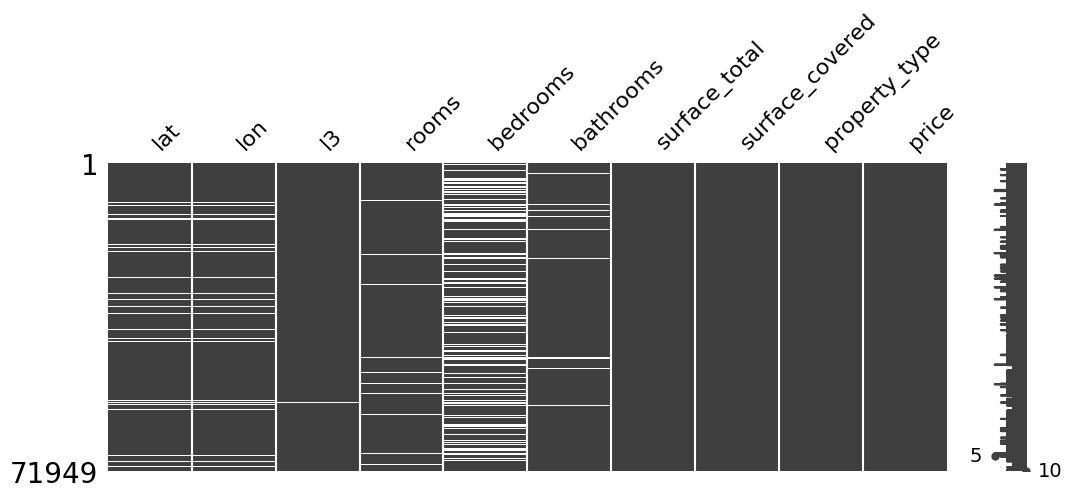

In [ ]:
#Matriz y Mapa de Calor df_ent
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

msno.matrix(df_ent, figsize=(12,4))


In [ ]:
#Imputar valores faltantes en bedrooms, rooms, bathrooms, lat y lon

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import numpy as np
import joblib

# Columnas a imputar
cols_mice = ['rooms', 'bedrooms', 'bathrooms']
cols_knn  = ['lat', 'lon']
num_pred  = ['surface_total', 'surface_covered']

mice_feats = cols_mice + num_pred + cols_knn
knn_feats  = cols_knn + num_pred

# 1. Reemplazar valores < 1 por NaN
for col in cols_mice:
    df_ent.loc[df_ent[col] < 1, col] = np.nan

# 2. MICE (para variables discretas)
mice = IterativeImputer(random_state=42, max_iter=10)
mice.fit(df_ent[mice_feats])
df_ent.loc[:, cols_mice] = mice.transform(df_ent[mice_feats])[:, :len(cols_mice)]

# 3. KNN (para geográficas)
knn = KNNImputer(n_neighbors=5, weights='distance')
knn.fit(df_ent[knn_feats])
df_ent.loc[:, cols_knn] = knn.transform(df_ent[knn_feats])[:, :len(cols_knn)]

# 4. Guardar imputadores
joblib.dump(mice, 'mice_ent.pkl')
joblib.dump(knn,  'knn_ent.pkl')

# 5. Control final
print("✔ NaN restantes en df_ent:")
print(df_ent[cols_mice + cols_knn].isna().sum())


✔ NaN restantes en df_ent:
rooms        0
bedrooms     0
bathrooms    0
lat          0
lon          0
dtype: int64


In [ ]:
#Redondear los roooms, bathrooms y bedrooms
cols_int = ['rooms', 'bedrooms', 'bathrooms']

df_ent[cols_int] = (
    df_ent[cols_int]
      .round()
      .astype('Int64')
)


In [ ]:
# Calculo de WoE + imputación con KNN (Codificar barrios y tratar NaN)
mean_price = df_ent.groupby('l3')['price'].mean()
global_mean = df_ent['price'].mean()
woe_final = np.log(mean_price / global_mean)
df_ent['l3_woe'] = df_ent['l3'].map(woe_final)


In [ ]:
# Creación de PROPERTY TYPE (codifica y rellena nan)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
import pandas as pd, numpy as np, joblib

# Codificar property_type
df_ent['ptype_code'] = (
    df_ent['property_type']
      .astype('category')
      .cat.codes
)
df_ent['ptype_NA'] = df_ent['ptype_code'].isna().astype(int)

# Imputar faltantes de ptype_code usando rooms, lat, lon
knn_feats = ['ptype_code', 'rooms', 'lat', 'lon']
knn_ptype = KNNImputer(n_neighbors=5, weights='distance')
df_ent[knn_feats] = knn_ptype.fit_transform(df_ent[knn_feats])

# Redondear, convertir a int y decodificar
df_ent['ptype_code'] = np.round(df_ent['ptype_code']).astype(int)
code2ptype = dict(enumerate(df_ent['property_type'].dropna()
                                         .astype('category')
                                         .cat.categories))

# Agregar etiquetas para los imputados nuevos
for i in range(len(code2ptype), df_ent['ptype_code'].max() + 1):
    code2ptype[i] = f'Imputed_{i}'

df_ent['property_type'] = df_ent['ptype_code'].map(code2ptype)

# Crear dummies y limpiar
df_ent = pd.get_dummies(df_ent, columns=['property_type'],
                        prefix='ptype', dtype='uint8')
df_ent = df_ent.drop(columns=['ptype_code', 'ptype_NA'])

# Guardar artefactos
ptype2code = {v: k for k, v in code2ptype.items()}
joblib.dump(knn_ptype, 'knn_ptype.pkl')
joblib.dump(ptype2code, 'ptype2code.pkl')


['ptype2code.pkl']

In [ ]:
#Invierte lat y lon si están mal ubicados
def corregir_lat_lon(df, lat_rango=(-35, -33), lon_rango=(-59, -57)):
    """
    - Detecta si las columnas lat / lon están invertidas.
    - Las intercambia si la mayoría de valores de 'lat' caen en rango de lon y vice-versa.
    """
    lat, lon = df['lat'], df['lon']

    # % de filas que caen en el rango típico de CABA
    pct_lat_en_lat = ((lat.between(*lat_rango)).mean())   # correcta
    pct_lat_en_lon = ((lat.between(*lon_rango)).mean())   # invertida
    pct_lon_en_lon = ((lon.between(*lon_rango)).mean())   # correcta
    pct_lon_en_lat = ((lon.between(*lat_rango)).mean())   # invertida

    # Condición de swap: la “lat” actual parece longitude y la “lon” parece latitude
    if pct_lat_en_lon > 0.5 and pct_lon_en_lat > 0.5:
        print("↺ Intercambiando columnas lat ↔ lon (detectada inversión)")
        df[['lat', 'lon']] = df[['lon', 'lat']]
    else:
        print("✓ lat y lon ya están en el orden correcto")

    return df
df_ent = corregir_lat_lon(df_ent)

↺ Intercambiando columnas lat ↔ lon (detectada inversión)


In [ ]:
#Verificar si lat y lon se encuentran dentro de CABA sino se imputa con knn
lat_min, lat_max = -34.705, -34.526
lon_min, lon_max = -58.531, -58.335

cols_ayuda   = ['rooms', 'bedrooms', 'bathrooms']
cols_imputar = ['lat', 'lon'] + cols_ayuda

# Máscaras
mask_caba  = (df_ent['lat'].between(lat_min, lat_max) &
              df_ent['lon'].between(lon_min, lon_max))
mask_fuera = ~mask_caba

# Entrenar KNN sólo con filas válidas
if mask_caba.sum() == 0:
    raise ValueError("No hay filas dentro de CABA para entrenar el KNN.")
knn_geo = KNNImputer(n_neighbors=5, weights='distance')
knn_geo.fit(df_ent.loc[mask_caba, cols_imputar])

# Imputar sólo lat/lon de filas fuera de CABA
if mask_fuera.sum() > 0:
    imputados = knn_geo.transform(df_ent.loc[mask_fuera, cols_imputar])
    df_ent.loc[mask_fuera, ['lat', 'lon']] = imputados[:, :2]
else:
    print("No había coordenadas fuera de CABA en df_ent")

# Guardar imputador para usar en df_ap
joblib.dump(knn_geo, 'knn_geo.pkl')


['knn_geo.pkl']

In [ ]:
#BINNING no supervisado K-MEANS
from sklearn.cluster import KMeans

#  Transformar a log el precio
df_ent['log_price'] = np.log1p(df_ent['price'])

#  Entrenar KMeans sobre el log del precio
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_ent['estrato_raw'] = kmeans.fit_predict(df_ent[['log_price']])

#  Ordenar clusters por promedio de log_price
orden_clusters = df_ent.groupby('estrato_raw')['log_price'].mean().sort_values().index.tolist()

#  Crear mapping real → orden lógico (0 = bajo, ..., 3 = lujo)
reorden_mapping = {cluster: orden for orden, cluster in enumerate(orden_clusters)}

# Mapear a nombres interpretables
mapa_estrato = {0: 'bajo', 1: 'medio', 2: 'alto', 3: 'lujo'}
df_ent['estrato'] = df_ent['estrato_raw'].map(reorden_mapping).map(mapa_estrato)

#  Eliminar log_price si ya no lo necesitás
df_ent.drop(columns=['log_price'], inplace=True)

orden_estrato = {'bajo': 0, 'medio': 1, 'alto': 2, 'lujo': 3}
df_ent['estrato_ordinal'] = df_ent['estrato'].map(orden_estrato)

df_ent = df_ent.drop(columns=['estrato_raw'])


In [ ]:
# Detección de outliers de precio relativos al promedio del barrio

#  Calcular precio promedio por barrio
mean_price_by_l3 = df_ent.groupby('l3')['price'].mean()

#  Mapear promedio al dataset
df_ent['price_mean_l3'] = df_ent['l3'].map(mean_price_by_l3)

#  Calcular ratio precio / promedio
df_ent['price_outlier_ratio'] = df_ent['price'] / df_ent['price_mean_l3']

#  Crear flag numérico único de outlier:
df_ent['price_outlier_flag'] = 0
df_ent.loc[df_ent['price_outlier_ratio'] > 3, 'price_outlier_flag'] = 1
df_ent.loc[df_ent['price_outlier_ratio'] < 1/3, 'price_outlier_flag'] = -1

#  Verificación
print("price_outlier_flag creado en df_ent:\n", df_ent['price_outlier_flag'].value_counts())


✔ price_outlier_flag creado en df_ent:
 price_outlier_flag
 0    65579
-1     4204
 1     2166
Name: count, dtype: int64


In [ ]:
#Elimino los outliers por encima
df_ent = df_ent[df_ent['price_outlier_flag'] != 1].copy()


In [ ]:
#Elimina los outliers por debajo
df_ent = df_ent[df_ent['price_outlier_flag'] != 1].copy()


In [ ]:
#Elimina columnas que identifican outliers que no van a poder replicarse el df_ap
df_ent = df_ent.drop(columns=['price_outlier_ratio', 'price_outlier_flag'])

## 3. Entrenamiento del modelos (AA)

In [ ]:
# Me quedo con las columnas numéricas o booleanas solamente
df_ent = df_ent.select_dtypes(['number', 'bool'])
print(df_ent.columns)
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

Index(['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price', 'l3_woe', 'ptype_Casa', 'ptype_Cochera',
       'ptype_Departamento', 'estrato_ordinal', 'price_mean_l3'],
      dtype='object')


In [ ]:
### Versión con train/test split
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

best_score_test = 1000000

### Usar sólo RandomForestRegressor o GradientBoostingRegressor
for n_estimators in [10, 50, 100, 300, 500, 700, 1000]:

    # for max_depth in [3, 5, 8, 10, 12]:
    # 	reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    for max_depth in [5, 10, 20, 30, 50, None]:
        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

        # Entrenamos el modelo
        _ = reg.fit(X_train, y_train)

        # Cálculo del error en entrenamiento (train)
        y_pred = reg.predict(X_train)
        score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

        # Cálculo del error en prueba (test)
        y_pred = reg.predict(X_test)
        score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

        best_score_test = min(best_score_test, score_test)

        print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f} - {best_score_test=:.2f}")

n_estimators=10 -- max_depth=5 --> score_train=60625.40 - score_test=60482.41 - best_score_test=60482.41
n_estimators=10 -- max_depth=10 --> score_train=39398.02 - score_test=46695.19 - best_score_test=46695.19
n_estimators=10 -- max_depth=20 --> score_train=20454.44 - score_test=41569.39 - best_score_test=41569.39
n_estimators=10 -- max_depth=30 --> score_train=19411.04 - score_test=41811.01 - best_score_test=41569.39
n_estimators=10 -- max_depth=50 --> score_train=19493.14 - score_test=41336.18 - best_score_test=41336.18
n_estimators=10 -- max_depth=None --> score_train=19493.14 - score_test=41336.18 - best_score_test=41336.18
n_estimators=50 -- max_depth=5 --> score_train=59681.50 - score_test=60770.07 - best_score_test=41336.18
n_estimators=50 -- max_depth=10 --> score_train=38265.70 - score_test=46689.79 - best_score_test=41336.18
n_estimators=50 -- max_depth=20 --> score_train=18713.55 - score_test=40873.91 - best_score_test=40873.91
n_estimators=50 -- max_depth=30 --> score_trai

KeyboardInterrupt: 

In [ ]:
### Versión con validación cruzada

best_score = 1000000

### Usar sólo RandomForestRegressor o GradientBoostingRegressor
for n_estimators in [10, 50, 100, 300, 500, 700, 1000]:

    # for max_depth in [3, 5, 8, 10, 12]:
    # 	reg = sk.ensemble.GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    for max_depth in [5, 10, 20, 30, 50, None]:
        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42,min_samples_leaf=100,min_samples_split=200)

        # Entrenamos el modelo (cross validation en 5 partes)
        scores = -1*sk.model_selection.cross_val_score(reg, X, y, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

        scores_mean = scores.mean()
        scores_std = scores.std()

        best_score = min(best_score, scores_mean)

        print(f"{n_estimators=} -- {max_depth=} --> {scores_mean=:.2f} - {scores_std=:.2f} - {best_score=:.2f}")

## Dataframe A Predecir

In [ ]:
df_ap = pd.read_csv(f"/content/drive/MyDrive/DATA MINING/fcen-dm-2025-prediccion-precio-de-propiedades/a_predecir.csv", index_col="id")
df_ap.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,currency,price_period,title,description,property_type,operation_type,price
id,,,,,,,,,,,,,,,,,,,,,
1068,Propiedad,2020-06-21,2020-06-27,2020-06-21,NaN,NaN,Argentina,Capital Federal,Palermo,Palermo Viejo,...,1.0,286.0,160.0,USD,NaN,Casa de 4 ambientes en Venta en Palermo viejo,TRIPLEX EN MEDIO TERRENO DE 4 AMB MUY AMPLIOS...,Casa,Venta,NaN
1069,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.426576,-34.590987,Argentina,Capital Federal,Palermo,NaN,...,5.0,444.0,270.0,USD,NaN,Casa de 8 ambientes en Venta en Palermo,OPORTUNIDAD!! Edificio en Block desarrollado e...,Casa,Venta,NaN
1073,Propiedad,2020-06-21,2020-06-24,2020-06-21,-58.479808,-34.631266,Argentina,Capital Federal,Floresta,NaN,...,2.0,166.0,120.0,USD,NaN,Venta de casa en PH en Floresta,Casa con muy buena distribución y de amplios a...,Casa,Venta,NaN
1082,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.437889,-34.603291,Argentina,Capital Federal,Villa Crespo,NaN,...,3.0,352.0,185.0,USD,NaN,Casa de 5 ambientes en Venta en Villa crespo,SON 185 METROS CUBIERNTOS CON COCHERA MAS PATI...,Casa,Venta,NaN
1091,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.476461,-34.602494,Argentina,Capital Federal,Villa del Parque,NaN,...,2.0,168.0,106.0,USD,NaN,Venta de casa de tres ambientes en Villa del P...,"Hermosa casa ubicada en zona residencial, sobr...",Casa,Venta,NaN


In [ ]:
df_ap.shape

(7012, 24)

#Pre - procesar datos de df_ap

In [ ]:
#Cambiar de ARS a USD
df_ap.loc[df_ap["currency"].str.upper().eq("ARS"), "currency"] = "USD"


In [ ]:
#Cambiar el contenido de l4 a l3
mascara1 = df_ap['l4'].notna()
df_ap.loc[mascara1, 'l3'] = df_ap.loc[mascara1, 'l4']

In [ ]:
#Elimina las columnas que no van a servir para el análisis.
df_ap  = df_ap.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
#Imputar NaN de rooms, bedrooms,bathrooms, surf_total y surf_covered
import joblib, pandas as pd, numpy as np

# 1 ─ Cargar imputadores entrenados con df_ent
mice = joblib.load('mice_ent.pkl')
knn  = joblib.load('knn_ent.pkl')

# 2 ─ Orden original con el que se entrenó MICE
mice_feats = list(mice.feature_names_in_)        # ya incluye rooms, beds…

# 3 ─ Verificar que df_ap tenga todas esas columnas
missing = [c for c in mice_feats if c not in df_ap.columns]
if missing:
    raise KeyError(f'Estas columnas faltan en df_ap: {missing}')

# 4 ─ Reordenar df_ap y transformar
imputed_mat = mice.transform(df_ap[mice_feats])
imputed_df  = pd.DataFrame(imputed_mat, columns=mice_feats, index=df_ap.index)

# 5 ─ Asignar SOLO las columnas que imputamos con MICE
cols_mice = ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
df_ap.loc[:, cols_mice] = imputed_df[cols_mice]

# 6 ─ Repetir lógica para KNN (lat/lon)
knn_feats = list(knn.feature_names_in_)
df_ap.loc[:, ['lat', 'lon']] = (
    knn.transform(df_ap[knn_feats])[:, :2]
)

# 7 ─ Redondear ambientes a enteros
amb_cols = ['rooms', 'bedrooms', 'bathrooms']
df_ap[amb_cols] = (
    df_ap[amb_cols].round().astype('Int64')
)

print('NaN restantes:\n', df_ap[cols_mice + ['lat','lon']].isna().sum())
print('dtypes ambientes:\n', df_ap[amb_cols].dtypes)


NaN restantes:
 rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
lat                0
lon                0
dtype: int64
dtypes ambientes:
 rooms        Int64
bedrooms     Int64
bathrooms    Int64
dtype: object


In [ ]:
#WoE + imputación con KNN (codifica l3 y trata NaN)

df_ap['l3_woe'] = df_ap['l3'].map(woe_final).fillna(woe_final.mean())


In [ ]:
#Codificar e imputar Property Type
import pandas as pd, numpy as np
from sklearn.impute import KNNImputer

df_ap = pd.get_dummies(df_ap, columns=['property_type'], prefix='ptype', dtype='uint8')

ptype_cols = [c for c in df_ap.columns if c.startswith('ptype_')]

cols_knn = ptype_cols + ['rooms', 'lat', 'lon']

knn_imputer = KNNImputer(n_neighbors=5, weights='distance')
df_ap[cols_knn] = knn_imputer.fit_transform(df_ap[cols_knn])

df_ap[ptype_cols] = np.round(df_ap[ptype_cols]).astype('uint8')

print("NaNs restantes tras imputación:", df_ap[cols_knn].isna().sum().sum())
print("Columnas dummy generadas:", ptype_cols)


NaNs restantes tras imputación: 0
Columnas dummy generadas: ['ptype_Casa', 'ptype_Cochera', 'ptype_Departamento']


In [ ]:
#Invertir lat y lon si es necesario
df_ap  = corregir_lat_lon(df_ap)

↺ Intercambiando columnas lat ↔ lon (detectada inversión)


In [ ]:
#Verificar si lat y lon se encuentran dentro de CABA sino se imputa con knn
lat_min, lat_max = -34.705, -34.526
lon_min, lon_max = -58.531, -58.335

cols_ayuda   = ['rooms', 'bedrooms', 'bathrooms']
cols_imputar = ['lat', 'lon'] + cols_ayuda

mask_caba_ap  = (df_ap['lat'].between(lat_min, lat_max) &
                 df_ap['lon'].between(lon_min, lon_max))
mask_fuera_ap = ~mask_caba_ap

knn_geo = joblib.load('knn_geo.pkl')   # cargamos el modelo entrenado

if mask_fuera_ap.sum() > 0:
    imputados_ap = knn_geo.transform(df_ap.loc[mask_fuera_ap, cols_imputar])
    df_ap.loc[mask_fuera_ap, ['lat', 'lon']] = imputados_ap[:, :2]
else:
    print("✔ No había coordenadas fuera de CABA en df_ap")


In [ ]:
#BINNING ESTRATO
df_ap['estrato_ordinal'] = pd.qcut(df_ap['l3_woe'], q=4, labels=[0, 1, 2, 3])

In [ ]:
# Hago la columna estrato_raw numérica.
df_ap['estrato_ordinal'] = pd.to_numeric(df_ap['estrato_ordinal'], errors='coerce')

In [ ]:
#Columna precio por metro cuadrado m2
df_ap['price_mean_l3'] = df_ap['l3'].map(mean_price_by_l3)

<Axes: >

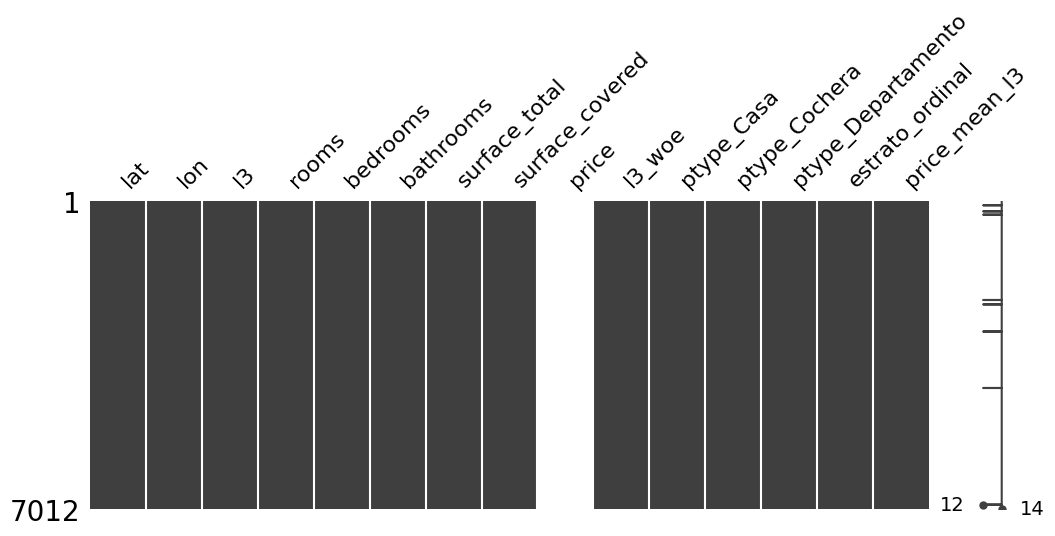

In [ ]:
msno.matrix(df_ap, figsize=(12,4))


In [ ]:
df_ap.head()

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,l3_woe,ptype_Casa,ptype_Cochera,ptype_Departamento,estrato_ordinal,price_mean_l3
id,,,,,,,,,,,,,,,
1068,-34.593272,-58.436996,Palermo Viejo,4.0,3,1,286.0,160.0,NaN,0.442254,1,0,0,3,409248.136986
1069,-34.590987,-58.426576,Palermo,9.0,7,5,444.0,270.0,NaN,0.214733,1,0,0,2,325968.590013
1073,-34.631266,-58.479808,Floresta,4.0,3,2,166.0,120.0,NaN,-0.504213,1,0,0,0,158833.261076
1082,-34.603291,-58.437889,Villa Crespo,5.0,4,3,352.0,185.0,NaN,-0.488872,1,0,0,0,161288.697747
1091,-34.602494,-58.476461,Villa del Parque,3.0,2,2,168.0,106.0,NaN,-0.424183,1,0,0,1,172067.120041


In [ ]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv, con los mejores hiperparámetros
n_estimators = 500
max_depth = 10
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42,min_samples_leaf=100,min_samples_split=200)

reg.fit(X, y)

RandomForestRegressor(max_depth=10, min_samples_leaf=100, min_samples_split=200,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# Hacemos en df_ap la misma limpieza que en df_ent

df_ap = df_ap.select_dtypes('number')

X_ap = df_ap[X.columns]

# Predecimos los precios del dataset a predecir
y_pred_ap = reg.predict(X_ap)
y_pred_ap

array([798172.15610606, 473711.01238835, 103330.86761391, ...,
       793930.70094402, 282148.76108917, 103542.42907955])

## 5. Importancia de las columnas

In [ ]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv, con los mejores hiperparámetros
n_estimators = 500
max_depth = 10
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42,min_samples_leaf=100,min_samples_split=200)

_ = reg.fit(X, y)

In [ ]:
# Importancia de las columnas
pd.DataFrame({"importance": reg.feature_importances_}, index=X.columns).sort_values(by="importance", ascending=False)

,importance
estrato_ordinal,0.837206
surface_total,0.059148
l3_woe,0.033346
price_mean_l3,0.031294
surface_covered,0.031173
lat,0.003717
lon,0.002105
bathrooms,0.001132
rooms,0.000659
bedrooms,0.000119


## 6. Análisis de errores

In [ ]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

n_estimators = 500
max_depth = 10

reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)
_ = reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [ ]:
X_test["error"] = abs(y_pred - y_test)
X_test["price"] = y_test
X_test["pred_price"] = y_pred
X_test.sort_values(by="error", ascending=False).head(10)

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,l3_woe,ptype_Casa,ptype_Cochera,ptype_Departamento,estrato_ordinal,price_mean_l3,error,price,pred_price
id,,,,,,,,,,,,,,,,
47807,-34.579757,-58.408121,7.0,5,4,266.0,266.0,1.207040,0,0,1,3,879283.759363,1.018028e+06,2200000.0,1.181972e+06
602158,-34.602005,-58.364010,7.0,4,5,331.0,271.0,1.284988,0,0,1,3,950564.107725,7.998751e+05,1250000.0,2.049875e+06
24271,-34.578288,-58.401186,8.0,5,8,580.0,580.0,1.207040,1,0,0,3,879283.759363,7.181031e+05,2600000.0,1.881897e+06
557302,-34.585220,-58.426652,6.0,4,4,350.0,260.0,1.207040,0,0,1,3,879283.759363,7.126622e+05,2300000.0,1.587338e+06
213527,-34.579757,-58.408121,5.0,4,3,330.0,276.0,1.207040,0,0,1,3,879283.759363,6.828773e+05,2200000.0,1.517123e+06
801693,-34.580562,-58.402234,3.0,2,2,193.0,193.0,1.207040,0,0,1,3,879283.759363,6.509617e+05,1550000.0,8.990383e+05
448103,-34.613151,-58.359421,5.0,4,4,296.0,286.0,1.284988,0,0,1,3,950564.107725,6.101524e+05,1700000.0,2.310152e+06
384028,-34.580615,-58.398508,5.0,2,3,260.0,260.0,1.207040,0,0,1,3,879283.759363,6.014249e+05,1000000.0,1.601425e+06
954487,-34.617719,-58.362056,4.0,3,5,242.0,182.0,1.284988,0,0,1,3,950564.107725,5.184519e+05,1850000.0,1.331548e+06
